In [158]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white")
import os
import plotly.express as px
from plotly.subplots import make_subplots
from plotly import graph_objects as go
import warnings
warnings.filterwarnings("ignore")

### Utilities

In [159]:
def compute_track_length(df):
    squared_diff = df[df.columns[:2]].diff().fillna(0).apply(np.square)
    res = (squared_diff['x']+squared_diff['y']).apply(np.sqrt)
    return res.sum()

### Determine Track Lengths

In [160]:
racecar_walker = pd.read_csv('../../pure_pursuit/waypoints/racecar_walker_29418.csv',header=None).rename(columns={0:"x",1:"y"})
track_porto = pd.read_csv('../../pure_pursuit/waypoints/track_porto_26780.csv',header=None).rename(columns={0:"x",1:"y"})
track_barca = pd.read_csv('../../pure_pursuit/waypoints/track_barca_4676.csv',header=None).rename(columns={0:"x",1:"y"})

In [161]:
walker = compute_track_length(racecar_walker)
porto = compute_track_length(track_porto)
barca = compute_track_length(track_barca)
barca_multiplier = barca/ porto
racecar_walker_multiplier = walker/porto
print("Porto Length:",porto)
print("Walker Length:",walker)
print("Barca Length:",barca)

Porto Length: 57.492612883355136
Walker Length: 73.2483359322749
Barca Length: 221.14172044855775


In [162]:
collisions_file_str = "collisions_{}_{}.csv"
progress_file_str = "progress_{}_{}.csv"
algorithms = ["e2e","e2e_all","sac","ddpg"]
tracks = ["track_porto","track_barca","racecar_walker"]
multipliers = {"track_porto":1.0,"track_barca":barca_multiplier,"racecar_walker":racecar_walker_multiplier}
distances = {"track_porto":porto,"track_barca":barca,"racecar_walker":walker}
relevant_columns = ['distance_traveled','laps_completed','time_elapsed']
collisions_dfs = [] 
progress_dfs = []
original_dfs = []
for i in algorithms:
    for j in tracks:
        collision_path = collisions_file_str.format(i,j)
        progress_path = progress_file_str.format(i,j)
        df = pd.read_csv(progress_path).iloc[:30].rename(columns=lambda col: col.strip())
        df['Controller'] = i
        df['Track'] = (j.split("_")[1]).capitalize()
        df['distance_traveled'] = df['laps_completed']*distances[j]
        df['laps_completed'] = df['laps_completed']*multipliers[j]
        original_dfs.append(df)
        
        
        df = df[relevant_columns].agg(['mean', 'median','std'])
        df['Controller'] = i
        df['Track'] = (j.split("_")[1]).capitalize()
        if(os.path.exists(collision_path)):
            c_df = pd.read_csv(collision_path).rename(columns=lambda col: col.strip())
            col_count = c_df[c_df["experiment_number"]<=30].shape[0]
            row = [[i,(j.split("_")[1]).capitalize(),col_count]]
        else:
            row = [[i,(j.split("_")[1]).capitalize(),0]]
        row_df = pd.DataFrame(row,columns=['Controller','Track','Number of Collisions'])
        collisions_dfs.append(row_df)
        progress_dfs.append(df)

In [163]:
progress = pd.concat(progress_dfs)
progress

,distance_traveled,laps_completed,time_elapsed,Controller,Track
mean,121.444596,2.112351,62.343133,e2e,Porto
median,125.353104,2.180334,62.324000,e2e,Porto
std,14.410147,0.250643,0.093819,e2e,Porto
mean,108.537979,1.887860,55.037033,e2e,Barca
median,123.074757,2.140706,62.305000,e2e,Barca
std,33.263152,0.578564,16.548745,e2e,Barca
mean,33.498509,0.582658,17.730167,e2e,Walker
median,33.904972,0.589727,17.999500,e2e,Walker
std,1.549549,0.026952,0.981322,e2e,Walker
mean,125.233782,2.178259,62.369200,e2e_all,Porto


In [164]:
collisions = pd.concat(collisions_dfs).reset_index().drop(columns="index")
collisions

,Controller,Track,Number of Collisions
0,e2e,Porto,0
1,e2e,Barca,5
2,e2e,Walker,30
3,e2e_all,Porto,0
4,e2e_all,Barca,0
5,e2e_all,Walker,0
6,sac,Porto,0
7,sac,Barca,30
8,sac,Walker,30
9,ddpg,Porto,0


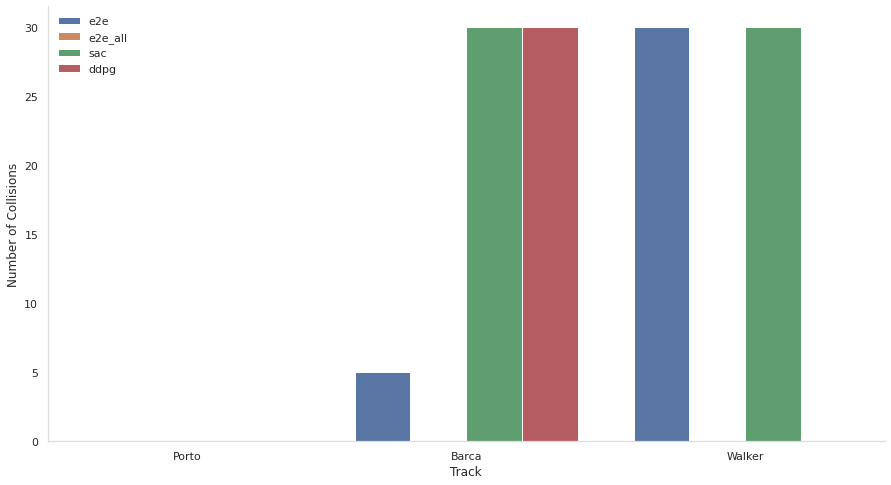

In [165]:
plt.figure(figsize=(15,8))
ax = sns.barplot(data=collisions, x="Track",y="Number of Collisions",hue="Controller")
ax.spines['bottom'].set_color('#dddddd')
ax.spines['left'].set_color('#dddddd')
sns.despine(left=False, bottom=False, right=True)
_= plt.legend(loc='upper left',frameon=False)

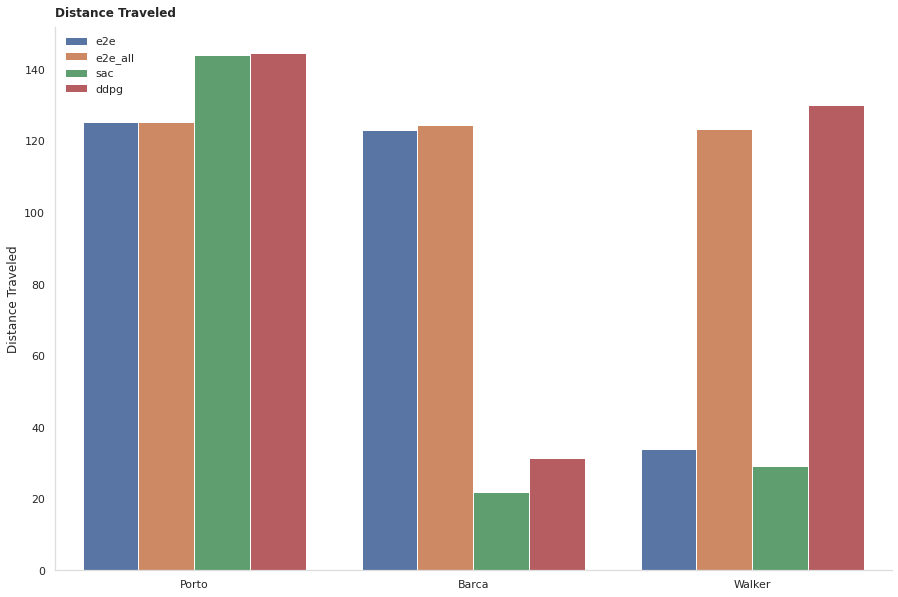

In [166]:
progress = pd.concat(progress_dfs).rename(columns={"distance_traveled":"Distance Traveled"})
plt.figure(figsize=(15,10))
ax = sns.barplot(data=progress[progress.index=='median'], x="Track",y="Distance Traveled",hue="Controller")
ax.spines['bottom'].set_color('#dddddd')
ax.spines['left'].set_color('#dddddd')
sns.despine(left=False, bottom=False, right=True)
_= plt.legend(loc='upper left',frameon=False)
_= plt.ylabel("Distance Traveled")
_= plt.xlabel('')
_= plt.title("Distance Traveled",loc='left',pad=10.0,fontweight="bold")

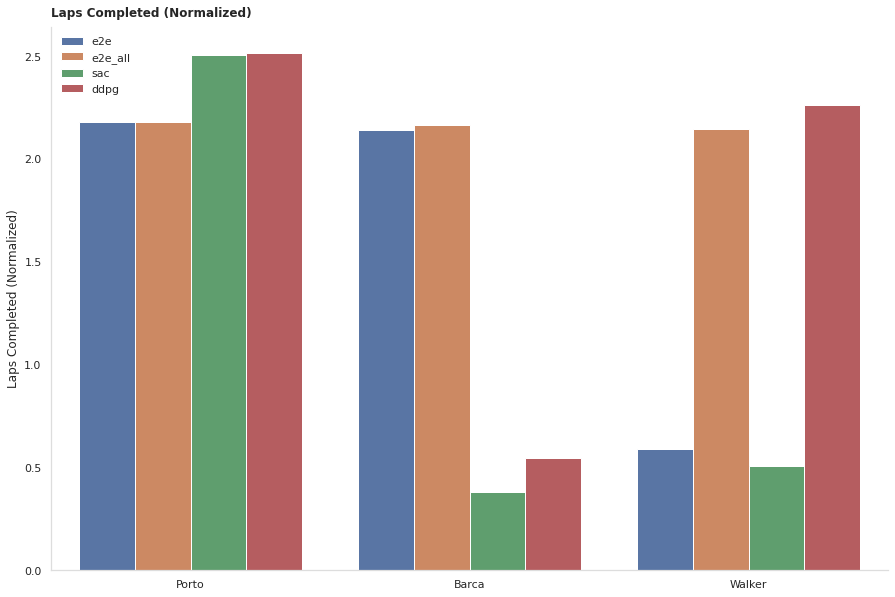

In [167]:
progress = pd.concat(progress_dfs).rename(columns={"laps_completed":"Normalized Laps Completed"})
plt.figure(figsize=(15,10))
ax = sns.barplot(data=progress[progress.index=='median'], x="Track",y="Normalized Laps Completed",hue="Controller")
ax.spines['bottom'].set_color('#dddddd')
ax.spines['left'].set_color('#dddddd')
sns.despine(left=False, bottom=False, right=True)
_= plt.legend(loc='upper left',frameon=False)
_= plt.ylabel('Laps Completed (Normalized)')
_= plt.xlabel('')
_= plt.title('Laps Completed (Normalized)',loc='left',pad=10.0,fontweight="bold")

In [168]:
all_dfs = pd.concat(original_dfs).rename(columns={"laps_completed":"Normalized Laps Completed","distance_traveled":"Distance Traveled"})
all_dfs

,Normalized Laps Completed,time_elapsed,experiment_number,Controller,Track,Distance Traveled
0,2.108580,62.370,1,e2e,Porto,121.227780
1,2.181473,62.324,2,e2e,Porto,125.418585
2,1.183751,62.324,3,e2e,Porto,68.056935
3,2.178436,62.271,4,e2e,Porto,125.243968
4,2.183751,62.357,5,e2e,Porto,125.549548
...,...,...,...,...,...,...
25,2.264317,62.325,26,ddpg,Walker,130.181497
26,2.255449,62.379,27,ddpg,Walker,129.671648
27,2.256927,62.285,28,ddpg,Walker,129.756623
28,2.259883,62.357,29,ddpg,Walker,129.926573


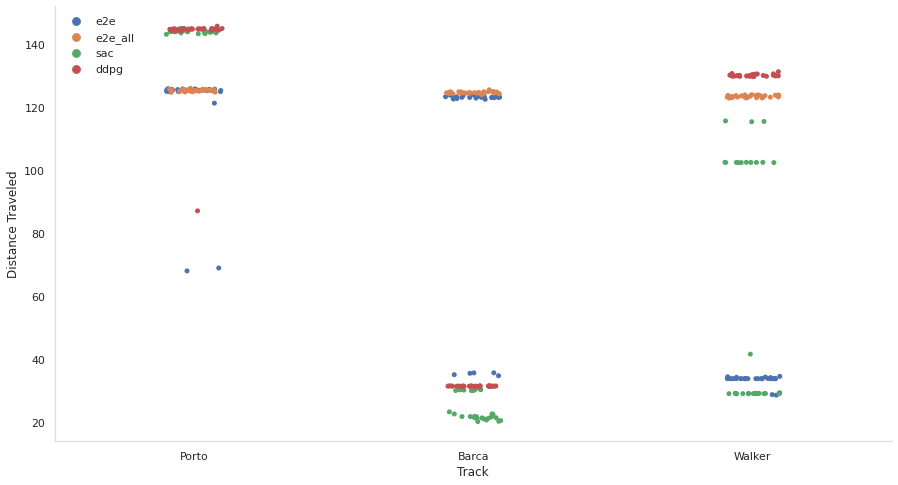

In [169]:
plt.figure(figsize=(15,8))
ax =  sns.stripplot(x="Track", y="Distance Traveled", data=all_dfs,hue='Controller')
ax.spines['bottom'].set_color('#dddddd')
ax.spines['left'].set_color('#dddddd')
sns.despine(left=False, bottom=False, right=True)
_= plt.legend(loc='upper left',frameon=False)

# Analysis of Varying the Speed 

In [170]:
# Experiment Parameters
algorithms = ["e2e","e2e_all","sac","ddpg"]
tracks = ["track_porto","track_barca","racecar_walker"]
speeds =  ["_0.5","","_1.5"]#["_0.5",


# file name templates
collisions_file_str = "collisions_{}_{}{}.csv"
progress_file_str = "progress_{}_{}{}.csv"
collisions_dfs = [] 
progress_dfs = []
original_dfs = []

for i in algorithms:
    for j in tracks:
        for k in speeds:
            collision_path = collisions_file_str.format(i,j,k)
            progress_path = progress_file_str.format(i,j,k)
            if(not k ):
                k="1.0"
            if(not os.path.exists(progress_path)):
                continue    
            #print('--------------------------------------------------------')
            df = pd.read_csv(progress_path).iloc[:30].rename(columns=lambda col: col.strip())
            df['Controller'] = i
            df['Track'] = (j.split("_")[1]).capitalize()
            df['Speed'] = k.replace("_","")
            df['distance_traveled'] = df['laps_completed']*distances[j]
            df['laps_completed'] = df['laps_completed']*multipliers[j]
            original_dfs.append(df)
            df = df[relevant_columns].agg(['mean', 'median','std'])
            df['Controller'] = i
            df['Track'] = (j.split("_")[1]).capitalize()
            df['Speed'] = k.replace("_","")
            #print(df)
            if(os.path.exists(collision_path)):
                c_df = pd.read_csv(collision_path).rename(columns=lambda col: col.strip())
                col_count = c_df[c_df["experiment_number"]<=30].shape[0]
                row = [[i,(j.split("_")[1]).capitalize(),col_count, k.replace("_","")]]
                #print("Number of Collisions",col_count)
            else:
                row = [[i,(j.split("_")[1]).capitalize(),0, k.replace("_","")]]
                #print("Number of Collisions",0)
            row_df = pd.DataFrame(row,columns=['Controller','Track','Number of Collisions','Speed'])
            collisions_dfs.append(row_df)
            progress_dfs.append(df)
            #print('--------------------------------------------------------')

In [171]:
collisions = pd.concat(collisions_dfs).reset_index().drop(columns="index")
collisions.head()

,Controller,Track,Number of Collisions,Speed
0,e2e,Porto,0,0.5
1,e2e,Porto,0,1.0
2,e2e,Porto,2,1.5
3,e2e,Barca,0,0.5
4,e2e,Barca,5,1.0


In [172]:
test[test['Track']=="Porto"]

,distance_traveled,laps_completed,time_elapsed,Controller,Track
mean,40.328298,0.550569,14.179700,ddpg,Porto
median,40.322736,0.550494,14.150000,ddpg,Porto
std,0.365541,0.004990,0.242279,ddpg,Porto
mean,41.798456,0.570640,16.982567,e2e,Porto
median,41.518514,0.566819,16.878500,e2e,Porto
std,0.879844,0.012012,0.456158,e2e,Porto
mean,40.788070,0.556846,16.689033,e2e_all,Porto
median,40.739868,0.556188,16.702500,e2e_all,Porto
std,0.260658,0.003559,0.173751,e2e_all,Porto
mean,182.983650,2.498127,62.251567,sac,Porto


In [174]:
test = pd.concat(progress_dfs).sort_values(by=['Speed','Controller'], ascending=True)
test = test[test['Track']=="Barca"]
test = test[test["Speed"]=='1.0']
test.loc[['mean','std']]

,distance_traveled,laps_completed,time_elapsed,Controller,Track,Speed
mean,31.536010,0.548523,17.541133,ddpg,Barca,1.0
mean,108.537979,1.887860,55.037033,e2e,Barca,1.0
mean,124.571073,2.166732,62.323567,e2e_all,Barca,1.0
mean,24.271613,0.422169,13.799733,sac,Barca,1.0
std,0.033128,0.000576,0.126967,ddpg,Barca,1.0
std,33.263152,0.578564,16.548745,e2e,Barca,1.0
std,0.293894,0.005112,0.081194,e2e_all,Barca,1.0
std,4.086429,0.071077,2.153001,sac,Barca,1.0


In [112]:
test = pd.concat(progress_dfs).sort_values(by=['Speed','Controller'], ascending=True)
test.loc[['std']]

,distance_traveled,laps_completed,time_elapsed,Controller,Track,Speed
std,0.224675,0.003908,0.090413,ddpg,Porto,0.5
std,0.027227,0.000474,0.083977,ddpg,Barca,0.5
std,0.141349,0.002459,0.136794,ddpg,Walker,0.5
std,0.368904,0.006417,0.097435,e2e,Porto,0.5
std,0.169892,0.002955,0.114960,e2e,Barca,0.5
std,0.007757,0.000135,0.180098,e2e,Walker,0.5
std,0.095504,0.001661,0.052035,e2e_all,Porto,0.5
std,0.275448,0.004791,0.117522,e2e_all,Barca,0.5
std,6.130758,0.106636,7.009317,e2e_all,Walker,0.5
std,10.051942,0.174839,8.632347,sac,Porto,0.5


In [105]:
pd.concat(progress_dfs)

Index(['mean', 'median', 'std', 'mean', 'median', 'std', 'mean', 'median',
       'std', 'mean',
       ...
       'std', 'mean', 'median', 'std', 'mean', 'median', 'std', 'mean',
       'median', 'std'],
      dtype='object', length=108)

In [95]:
progress = pd.concat(progress_dfs).rename(columns={"laps_completed":"Normalized Laps Completed"})
progress.head()

,distance_traveled,Normalized Laps Completed,time_elapsed,Controller,Track,Speed
mean,64.723208,1.125766,62.349067,e2e,Porto,0.5
median,64.761041,1.126424,62.341000,e2e,Porto,0.5
std,0.368904,0.006417,0.097435,e2e,Porto,0.5
mean,121.444596,2.112351,62.343133,e2e,Porto,1.0
median,125.353104,2.180334,62.324000,e2e,Porto,1.0


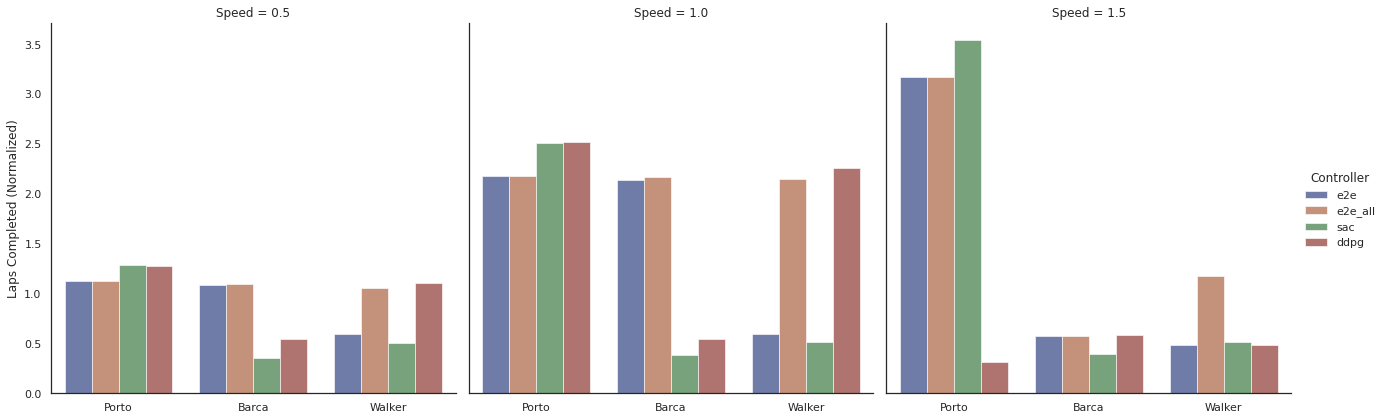

In [96]:
g = sns.catplot(
    data=progress[progress.index=='median'], kind="bar",
    x="Track", y="Normalized Laps Completed", hue="Controller", col='Speed',
    ci="sd", palette="dark", alpha=.6, height=6
)
g.set_axis_labels( "" , "Laps Completed (Normalized)" ) 
# Title for the complete figure 
#g.fig.suptitle("Laps Completed (Normalized) vs. Velocity" , 
#               va='top',
#               ha='left',
#               fontsize = 'large' ,  
#               fontweight = 'bold') 

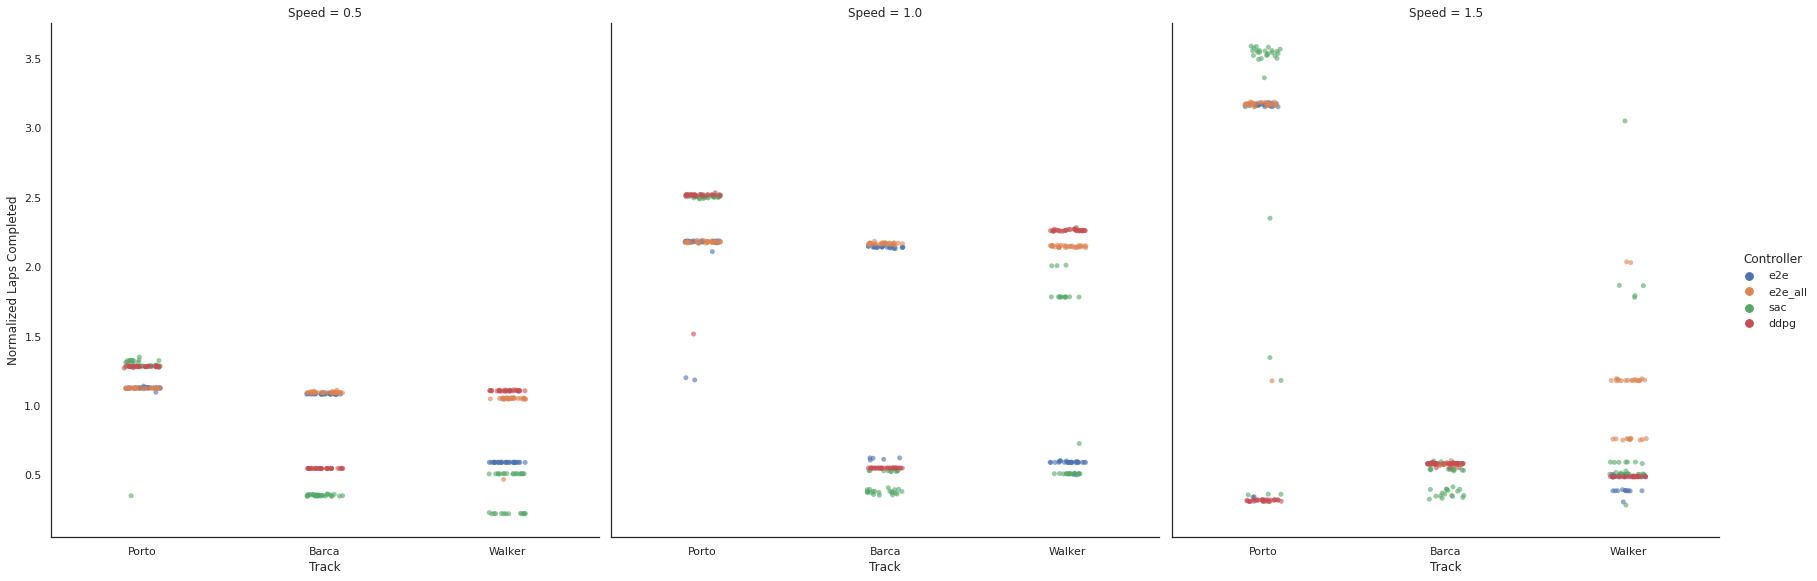

In [16]:
all_dfs = pd.concat(original_dfs).rename(columns={"laps_completed":"Normalized Laps Completed"})
g = sns.catplot(
    data=all_dfs, kind="strip",
    x="Track", y="Normalized Laps Completed", hue="Controller", col='Speed',
    ci="sd", alpha=.6, height=8, aspect = 1.0,
)

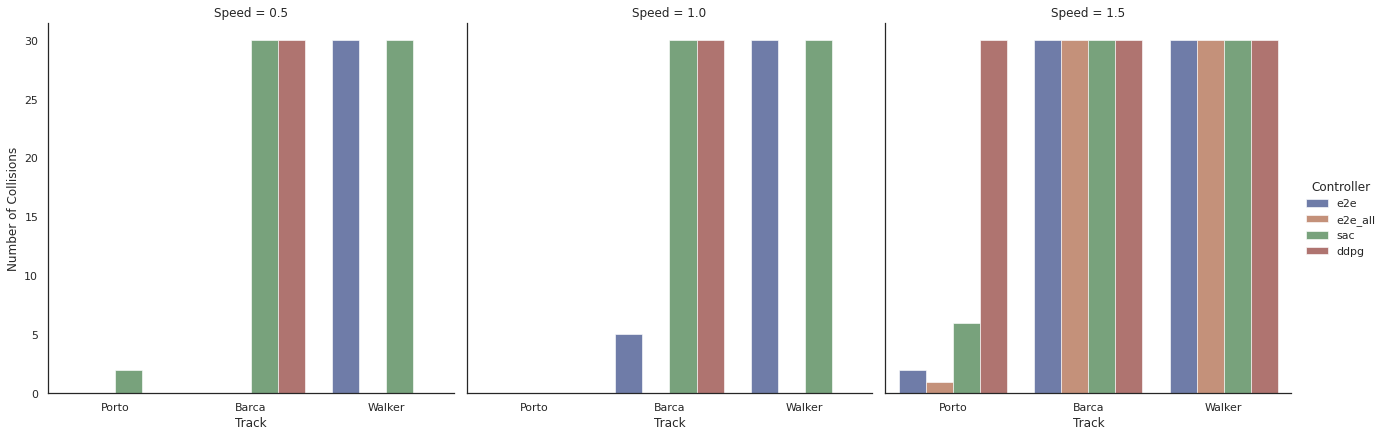

In [17]:
g = sns.catplot(
    data=collisions, kind="bar",
    x="Track", y="Number of Collisions", hue="Controller", col='Speed',
    ci="sd", palette="dark", alpha=.6, height=6, aspect = 1.0,
)

### Experiments with Cones

In [153]:
collisions_file_str = "collisions_{}_{}_1.0_cones.csv"
progress_file_str = "progress_{}_{}_1.0_cones.csv"
algorithms = ["e2e","e2e_all","sac","ddpg"]
collisions_dfs = [] 
progress_dfs = []
original_dfs = []
for i in algorithms:
    collision_path = collisions_file_str.format(i,'track_porto')
    progress_path = progress_file_str.format(i,'track_porto')
    df = pd.read_csv(progress_path).iloc[:30].rename(columns=lambda col: col.strip())
    df['Controller'] = i
    df['Track'] = "Porto"
    df['distance_traveled'] = df['laps_completed']*distances[j]
    #df['laps_completed'] = df['laps_completed']*multipliers[j]
    original_dfs.append(df)
    df = df[relevant_columns].agg(['mean', 'median','std'])
    df['Controller'] = i
    df['Track'] = "Porto"
    #print(df)
    if(os.path.exists(collision_path)):
        c_df = pd.read_csv(collision_path).rename(columns=lambda col: col.strip())
        col_count = c_df[c_df["experiment_number"]<=30].shape[0]
        row = [[i,(j.split("_")[1]).capitalize(),col_count]]
        #print("Number of Collisions",col_count)
    else:
        row = [[i,(j.split("_")[1]).capitalize(),0]]
            #print("Number of Collisions",0)
    row_df = pd.DataFrame(row,columns=['Controller','Track','Number of Collisions'])
    collisions_dfs.append(row_df)
    progress_dfs.append(df)

In [156]:
progress = pd.concat(progress_dfs)
test = pd.concat(progress_dfs).sort_values(by=['Controller'], ascending=True)
test = test[test['Track']=="Porto"]
test.loc[['mean','std']]

,distance_traveled,laps_completed,time_elapsed,Controller,Track
mean,40.328298,0.550569,14.179700,ddpg,Porto
mean,41.798456,0.570640,16.982567,e2e,Porto
mean,40.788070,0.556846,16.689033,e2e_all,Porto
mean,182.983650,2.498127,62.251567,sac,Porto
std,0.365541,0.004990,0.242279,ddpg,Porto
std,0.879844,0.012012,0.456158,e2e,Porto
std,0.260658,0.003559,0.173751,e2e_all,Porto
std,2.924881,0.039931,0.651733,sac,Porto


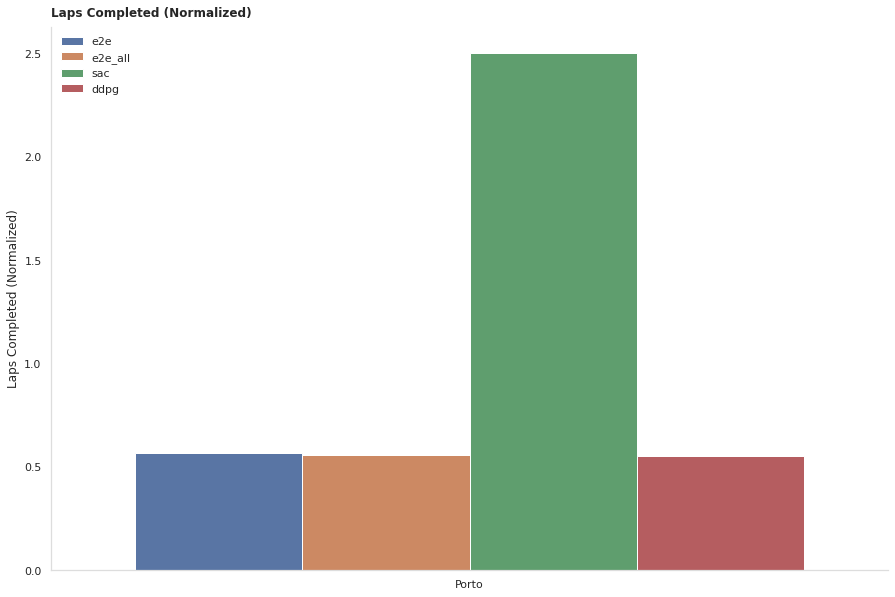

In [132]:
progress = pd.concat(progress_dfs)
progress = pd.concat(progress_dfs).rename(columns={"laps_completed":"Normalized Laps Completed"})
plt.figure(figsize=(15,10))
ax = sns.barplot(data=progress[progress.index=='median'], x="Track",y="Normalized Laps Completed",hue="Controller")
ax.spines['bottom'].set_color('#dddddd')
ax.spines['left'].set_color('#dddddd')
sns.despine(left=False, bottom=False, right=True)
_= plt.legend(loc='upper left',frameon=False)
_= plt.ylabel('Laps Completed (Normalized)')
_= plt.xlabel('')
_= plt.title('Laps Completed (Normalized)',loc='left',pad=10.0,fontweight="bold")

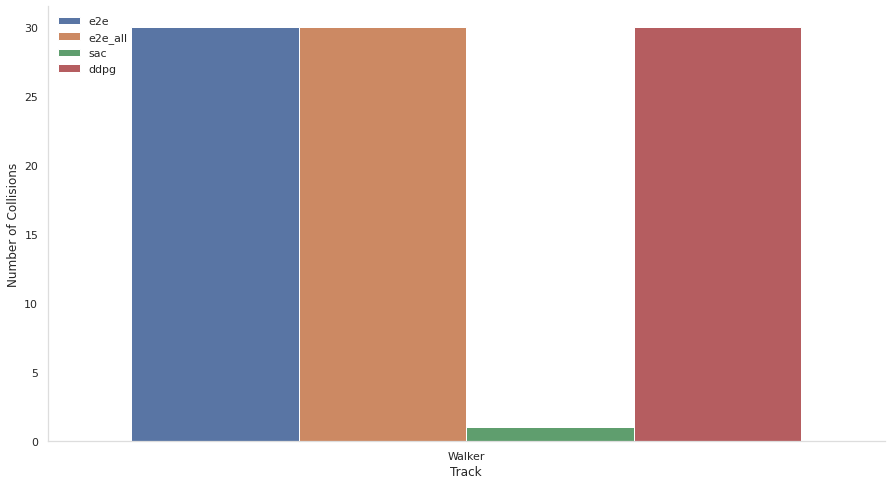

In [20]:
collisions = pd.concat(collisions_dfs).reset_index().drop(columns="index")
plt.figure(figsize=(15,8))
ax = sns.barplot(data=collisions, x="Track",y="Number of Collisions",hue="Controller")
ax.spines['bottom'].set_color('#dddddd')
ax.spines['left'].set_color('#dddddd')
sns.despine(left=False, bottom=False, right=True)
_= plt.legend(loc='upper left',frameon=False)